# 3. MLP基礎（バッチ編）解説

## 概要
本演習ではChapter03で学習した、深層学習の基礎である多層パーセプトロン(バッチ処理)を穴埋め形式で実装しました。<br>
演習問題文は<font color="Red">赤字</font>で表示されています。<br>


## ライブラリのインポート
必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
%matplotlib inline
# 乱数シードを指定
np.random.seed(seed=0)

今回もデータセットとしてMNISTを使用し、`sklearn`の`train_test_split`を用いて訓練データ:テストデータ = 8:2 に分割します。

In [ ]:
if os.path.exists('mnist_784'):
    with open('mnist_784','rb') as f:
        mnist = pickle.load(f)
else:
    mnist = datasets.fetch_openml('mnist_784', as_frame=False)
    with open('mnist_784', 'wb') as f:
        pickle.dump(mnist, f)
# 画像とラベルを取得
X, T = mnist.data, mnist.target
# 訓練データとテストデータに分割
x_train, x_test, t_train, t_test = train_test_split(X, T, test_size=0.2)

# ラベルデータをint型にし、one-hot-vectorに変換します
t_train = np.eye(10)[t_train.astype("int")]
t_test = np.eye(10)[t_test.astype("int")]

## 最適化・バッチ正規化・ミニバッチ学習（スクラッチ）

### データのサンプリング
画像・ラベルデータをランダムにいくつか取り出して可視化します。
画像は784要素の1次元ベクトルとしてXに格納されていますが、画像として表示するときは28x28の二次元にreshapeします。

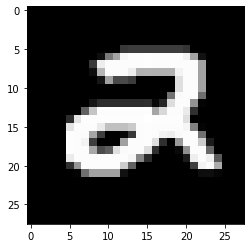

Label:  2


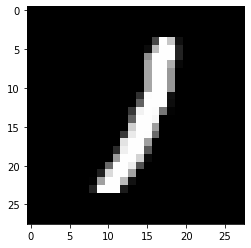

Label:  1


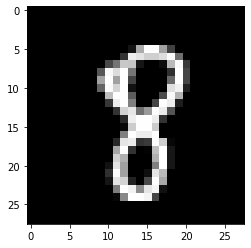

Label:  8


In [ ]:
# テストデータをランダムサンプリング
perm = np.random.permutation(len(x_test))
# サンプル画像を表示する
plt.gray()
for i in perm[:3]:
    plt.imshow(x_test[perm[i]].reshape(28, 28))
    plt.show()
    print('Label: ', np.argmax(t_test[perm[i]]))

## Optimizerの実装


<font color="Red">問1. 確率的勾配降下法を用いたOptimizerのクラス SGD を完成させてください。</font><br>
SGDの特徴は、データを変えることによって、損失関数自体を確率的に変えられる点です。これによって、パラメータは同じであっても、勾配の向きを確率的に変えることができます。
この問題ではSGDのコードを回答してください。

In [ ]:
class SGD:

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] ### 問1 ###

#### <font color="Red">問1 解説</font>

SGDでは、学習係数```lr```と勾配値```grad```を用いて、パラメータ```params```<font color="lightblue">を</font>更新することが目的です。

また、SGDによるパラメータの更新の式は以下の通りになります。

$$ \text{params} = \text{params} - lr * \text{grad} $$

これをコードで表現すると、以下の通りになります。


```
params = params - self.lr * grads
```

しかし、上記のコードの場合```params```が2度出てきてしまい、少しくどい気がするかと思います。そこで、次のような表現を用いても同じ意味を表すことができます。

```
params -= self.lr * grads
```

```-=```を用いることで、```params```を1回のみ使って表すことができました。慣れてきたら是非こちらの方法も使ってみてください。今回はせっかくなので```params -= self.lr * grads```を使って説明します。

また、これを```params```及び```grads```が持つキーごとに行うため

```
for key in params.keys():
    params[key] -= self.lr * grads[key] 
```

となります。```params.keys()```を用いることで、```params```が持つキー（```{"ID":0001}```の```ID```の部分）をリストとして全て取得することができます。そして、リストの要素を１つずつ取得しているのが```key```となります。

これに加えて、```lr```の定義やパラメータを更新するメソッドなどを作成することで完成します。

従って、答えは以下の通りになります。

```
class SGD:

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 
```

<font color="Red">問2. Adamクラス を完成させてください。</font><br>

Adamの特徴としてハイパーパラメータのバイアス補正(偏りの補正)が行われることが挙げられます。書籍『ゼロから作るDeepLearning』の配布コードは簡易版のため、バイアス補正を組み込んでいません。<br>
この問題ではバイアス補正を組み込んだ完成形のAdamコードについて回答してください。また、過去のE資格試験ではこちらの完成形のAdamコードが出題されています。

In [ ]:
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        
        for key in params.keys():
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]###### 問2-1 ######
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * grads[key]**2###### 問2-2 ######
            m_unbias = self.m[key] / (1-self.beta1 ** self.iter)###### 問2-3 ######
            v_unbias = self.v[key] / (1-self.beta2 ** self.iter)###### 問2-4 ######
            params[key] -= self.lr * m_unbias / (np.sqrt(v_unbias) + 1e-7)

"""
以下、ゼロから作るDeepLearningに記載されているコードです。
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)
"""

#### <font color="Red">問2 解説</font>

まず、Adamの式について考えてみます。Adamの式は、講義スライドに載っているので、復習時に合わせてご覧ください。

Adamではまず、```m```と```v```という２つの変数の更新を行います。

```m```の更新については、ハイパーパラメータ```beta1```と勾配値```grads```を用いると次のように表現することができます。

$$ m = \text{beta1} * m + (1 - \text{beta1}) * \text{grad} $$

上記と同じように、```v```の更新については、ハイパーパラメータ```beta2```と勾配値```grads```を用いると次のように表現することができます。

$$ v = \text{beta2} * v + (1 - \text{beta2}) * \text{grad}^2 $$

次に、```m```と```v```のバイアスの補正について説明します。

ここでは```m```のバイアス補正を```m-unbias```とします。```m```とハイパーパラメータ```iter```と```beta1```で表すと以下の通りになります。

$$ \text{m-unbias} = \frac{m}{1 - \text{beta1}^\text{iter}} $$

上記と同じようにして、```v```のバイアス補正を```v-unbias```とします。```v```とハイパーパラメータ```iter```と```beta2```で表すと以下の通りになります。

$$ \text{v-unbias} = \frac{m}{1 - \text{beta2}^\text{iter}} $$

最後に、パラメータ```params```の更新を行います。

これまで求めたものとハイパーパラメータ```lr```を用いて、パラメータの更新を行うと以下の通りになります。

$$ \text{params} = \text{params} - \text{lr} * \frac{\text{m-unbias}}{\sqrt{\text{v-unbias}} + ϵ} $$

なお、$ϵ$についてですが、$\text{v-unbias} = 0$のとき、分母が0になることでゼロ除算することを防ぐために加えます。$ϵ$は微小値（10^(-7)など）で構いません。

上記の式を算出することで、Adamによるパラメータの更新を行うことができます。

これらをコードに表現することができれば、完成です。以下のようになります。

```
m = beta1 * m + (1 - beta1) * grads
v = beta2 * v + (1 - beta2) * grads**2
m_unbias = m / (1-beta1 ** iter)
v_unbias = v / (1-beta2 ** iter)
params -= lr * m_unbias / (np.sqrt(v_unbias) + ϵ)
```

あとは、定義されている形（selfをつけるなど）や```grad```や```params```などのパラメータについては、キーごとに更新するといったことなどに気をつけて修正すれば完成です。

従って、答えは以下のようになります。

```
for key in params.keys():
    self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
    self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * grads[key]**2
    m_unbias = self.m[key] / (1-self.beta1 ** self.iter)
    v_unbias = self.v[key] / (1-self.beta2 ** self.iter)
    params[key] -= self.lr * m_unbias / (np.sqrt(v_unbias) + 1e-7)

# ϵ = 1e-7 (10^(-7))
```

#### コスト関数

多クラス分類問題なので、クロスエントロピーをコスト関数として用います。

In [ ]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [ ]:
def softmax(x):
    x = x.T
    x = x - np.max(x, axis=0)
    x = np.exp(x) / np.sum(np.exp(x), axis=0)
    return x.T

## バッチ正規化を用いないMLP

まずはバッチ正規化を入れない普通の三層ニューラルネットワークを実装します。問題にはなっていませんが、chapter02の復習も兼ねてコードを読み理解しておいてください。

In [ ]:
class mnistMultiLayerNet:
    """
    layer0: 784 次元の入力
    ↓ w1, b1 で線形結合
    ↓ relu で活性化
    layer1: 100 次元の隠れ層
    ↓ w2, b2 で線形結合
    ↓ relu で活性化
    layer2: 100 次元の隠れ層
    ↓ w3, b3 で線形結合
    ↓ relu で活性化
    layer3: 100 次元の隠れ層
    ↓ w4, b4 で線形結合
    ↓ relu で活性化
    layer4: 100 次元の隠れ層
    ↓ w5, b5 で線形結合
    layer5: 10 次元の出力層
    """
    def __init__(self):
        self.input_size = 784
        self.output_size = 10
        self.hidden_size_list = [100, 100, 100, 100]
        self.all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        self.hidden_layer_num = len(self.hidden_size_list)
        self.weight_decay_lambda =0
        self.params = {}
        self.layers = {}
        self.grads = {}

        # 重みとバイアスの初期化
        for idx in range(1, len(self.all_size_list)):
            self.params['w' + str(idx)] = np.random.randn(self.all_size_list[idx-1], self.all_size_list[idx]) * 0.085
            self.params['b' + str(idx)] = np.zeros(self.all_size_list[idx], dtype=float)

        
    def forward(self, x):
        relu = lambda x : np.maximum(0, x)  # 活性化関数として ReLU を使用
        self.layers['layer0'] = x
        for idx in range(1, len(self.all_size_list) - 1):
            w = self.params['w' + str(idx)]
            b = self.params['b' + str(idx)]
            x = self.layers['layer' + str(idx - 1)]
            self.layers['layer' + str(idx)] = relu(np.dot(x, w) + b)
        idx = len(self.all_size_list) - 1
        w = self.params['w' + str(idx)]
        b = self.params['b' + str(idx)]
        x = self.layers['layer' + str(idx - 1)]
        self.layers['layer' + str(idx)] = softmax(np.dot(x, w) + b)
        
        return self.layers['layer' + str(idx)]
        

    def loss(self, y, t):
        return cross_entropy_error(y, t)
    
    def backward(self, t, y):
        delta = (y - t) / t.shape[0]
        self.grads['b5'] = np.sum(delta, axis=0)
        self.grads['w5'] = np.dot(self.layers['layer4'].transpose(), delta)
        # 誤差逆伝播
        for idx in range(4, 0, -1):
            delta = np.dot(delta, self.params['w' + str(idx + 1)].transpose())
            delta = delta *  (self.layers['layer' + str(idx)] > 0)
            self.grads['b' + str(idx)] = np.sum(delta, axis=0)
            self.grads['w' + str(idx)] = np.dot(self.layers['layer'+str(idx - 1)].transpose(), delta)
        return self.grads


## バッチ正規化を用いたMLP
* <font color="Red">問3. バッチ正規化を用いたMLPクラスを完成させる</font><br>
    * <font color="Red">問3-1. 【forward関数】ミニバッチの平均を算出する処理を記述してください。</font><br>
    * <font color="Red">問3-2. 【forward関数】ミニバッチの分散を算出する処理を記述してください。</font><br>
    * <font color="Red">問3-3. 【forward関数】移動平均により全体の平均を求める処理を記述してください。</font><br>
    * <font color="Red">問3-4. 【forward関数】移動平均により全体の分散を求める処理を記述してください。</font><br>
    * <font color="Red">問3-5,3-6. 【forward関数】テスト時における全体の平均と分散を使った正規化する処理を記述してください。</font><br>
    * <font color="Red">問3-7,3-8. 【backward関数】β, γの勾配を算出する処理を記述してください。</font><br>

各層について、重みを掛けて足し合わせた後バッチ正規化を行う。

バッチ正規化の順伝播は以下の式に従って実装します。

- （訓練時のみ）まずは計算しているミニバッチについて、平均と分散を求めます。各次元について、全データを通じた平均・分散を計算するため、平均・分散を計算する軸にご注意ください。

- （訓練時のみ）テスト時に使用するために、訓練データ全体での平均を推定します。モーメンタム $m$ を用いて今までの平均 $\mu_{old} $ を計算しているミニバッチの平均 $\mu$ の方向に移動させ、新しい平均$\mu_{new} $を求めます。
$$
\mu_{new} = m \mu_{old} + ( 1 - m)\mu\tag{1}
$$

- （訓練時のみ）同様に今までの分散 $\sigma_{old} ^ 2$ を計算しているミニバッチの平均 $\sigma^2$の方向に移動させ、 新しい分散$\sigma_{new}^2$ を求めます。
$$
\sigma_{new}^2 = m \sigma_{old}^2 + ( 1 - m)\sigma^2\tag{2}
$$

- 求めた平均 $\mu$ と分散 $\sigma^2$ を用いて、入力 $x$ を正規化した値 $x_n$ を求めます。分散$\sigma^2$から標準偏差 $\sigma$ を求めるときに、アンダーフローを避けるために 10e-6 ($10 \times 10 ^ {-7}$) を足してから平方根を取っています。
テスト時には、移動平均により推定した訓練データ全体での平均・分散を使用します。
$$
\sigma = \sqrt{\sigma ^ 2 + 10 \times 10 ^ {-7}}\tag{3}
$$
$$
x_n = (x - \mu) / \sigma\tag{4}
$$

- 正規化した値 $x_n$に対して $\gamma$ を用いて変倍し、$\beta$ を用いて移動を行い、活性化関数に渡す出力 $y$ を求めます。
$$
y = \gamma x_n + \beta\tag{5}
$$

バッチ正規化の誤差逆伝播は以下の式に従って実装します。

- 直前まで逆伝播してきた$1, 2, \dots , N$ 番目(Nはバッチサイズ)の出力データ$y_k$による勾配 $\frac{\partial L}{\partial y_k}$を用いて $\gamma$ と$\beta$による勾配を計算します。 $x_{nk}$ はミニバッチの中のk番目の入力データを正規化した後の値を表します。

$$
   \begin{eqnarray} 
   \frac{\partial L}{\partial \gamma} & = & \sum_{k=1}^{N} \frac{\partial L}{\partial y_k} \frac{\partial y_k}{\partial \gamma} = \sum_{k=1}^{N} \frac{\partial L}{\partial y_k} x_{nk}\tag{6}\\
    \frac{\partial L}{\partial \beta} & = & \sum_{k=1}^{N} \frac{\partial L}{\partial y_k} \frac{\partial y_k}{\partial \beta} =  \sum_{k=1}^{N} \frac{\partial L}{\partial y_k}\tag{7}
    \end{eqnarray}
$$

- $1, 2, \dots , N$ 番目の入力データ$x_k$による勾配 $\frac{\partial L}{\partial x_k}$を計算します（コードでは高速化のため少々異なった計算をしています）。

$$
\begin{equation} 
\frac{\partial L}{\partial x_k} 
= \frac{\gamma}{\sigma} \Bigg[ \frac{\partial L}{\partial y_k} 
- \frac{1}{N} \bigg[ \frac{\partial L}{\partial \beta} + x_{nk} \frac{\partial L}{\partial \gamma} \bigg] \Bigg] 
\end{equation}
$$

In [ ]:
class mnistMultiLayerBatchNet:
    """
    layer0: 784 次元の入力
    ↓ w1, b1 で線形結合
    ↓バッチ正規化 gamma1倍しbeta1だけずらす
    ↓ relu で活性化
    layer1: 100 次元の隠れ層
    ↓ w2, b2 で線形結合
    ↓バッチ正規化 gamma2倍しbeta2だけずらす
    ↓ relu で活性化
    layer2: 100 次元の隠れ層
    ↓ w3, b3 で線形結合
    ↓バッチ正規化 gamma3倍しbeta3だけずらす
    ↓ relu で活性化
    layer3: 100 次元の隠れ層
    ↓ w4, b4 で線形結合
    ↓バッチ正規化 gamma4倍しbeta4だけずらす
    ↓ relu で活性化
    layer4: 100 次元の隠れ層
    ↓ w5, b5 で線形結合
    layer5: 10 次元の出力層
    """
    def __init__(self):
        self.input_size = 784
        self.output_size = 10
        self.hidden_size_list = [100, 100, 100, 100]
        self.all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        self.hidden_layer_num = len(self.hidden_size_list)
        self.weight_decay_lambda =0
        self.params = {}
        self.layers = {}
        self.grads = {}
        self.norms = {}
        self.momentum = 0.9

        # パラメータの初期化
        for idx in range(1, len(self.all_size_list)):
            # 線形結合層のパラメータ
            self.params['w' + str(idx)] = np.random.randn(self.all_size_list[idx-1], self.all_size_list[idx]) * 0.085
            self.params['b' + str(idx)] = np.zeros(self.all_size_list[idx], dtype=float)
            
            # バッチ正規化でシフトさせるときに用いるγとβを更新するパラメータとし初期化
            # mu と sigma は実行時の平均と分散
            if idx != len(self.all_size_list) - 1:
                self.params['gamma' + str(idx)] = np.ones(self.all_size_list[idx])
                self.params['beta' + str(idx)] = np.zeros(self.all_size_list[idx])
                self.norms['mu' + str(idx)] = None
                self.norms['var' + str(idx)] = None
        
    def forward(self, x, train_flg=False):
        relu = lambda x : np.maximum(0, x)  # 活性化関数として ReLU を使用
        self.layers['layer0'] = x
        for idx in range(1, len(self.all_size_list) - 1):
            # 線形結合層
            w = self.params['w' + str(idx)]
            b = self.params['b' + str(idx)]
            x = self.layers['layer' + str(idx - 1)]
            x = np.dot(x, w) + b
            
            # バッチ正規化
            # 平均と分散の初期化
            if self.norms['mu' + str(idx)] is None:
                N, D = x.shape
                self.norms['mu' + str(idx)] = np.zeros(D)
                self.norms['var' + str(idx)] = np.zeros(D)
            if train_flg:
                mu = x.mean(axis=0)           # 今回のミニバッチの平均###### 問3-1 ######
                xc = x - mu                   # 今回のミニバッチの平均との差分
                var = np.mean(xc**2, axis=0)  # 今回のミニバッチの分散###### 問3-2 ###### 
                std = np.sqrt(var + 10e-7)    # 今回のミニバッチの標準偏差
                xn = xc / std                 # 正規化

                # 全体の平均と分散を移動平均により求める(1),(2)
                self.norms['mu' + str(idx)] = self.momentum * self.norms['mu' + str(idx)] + (1-self.momentum) * mu###### 問3-3 ######
                self.norms['var' + str(idx)] = self.momentum * self.norms['var' + str(idx)] + (1-self.momentum) * var###### 問3-4 ######
                
                # 誤差逆伝播で使う中間データ
                self.norms['xc' + str(idx)] = xc
                self.norms['xn' + str(idx)] = xn
                self.norms['std' + str(idx)] = std
                self.norms['size' + str(idx)] = x.shape[0]
            else:
                # テスト時は全体の平均と分散を使って正規化する(3),(4)
                xc = x - self.norms['mu' + str(idx)]###### 問3-5 ######
                xn = xc / ((np.sqrt(self.norms['var' + str(idx)] + 10e-7)))###### 問3-6 ######
                
            # γ,βを用いてシフトさせる(5)
            shifted = self.params['gamma' + str(idx)] * xn + self.params['beta' + str(idx)]
            
            # relu を使って活性化
            self.layers['layer' + str(idx)] = relu(shifted)

        # 出力層
        idx = len(self.all_size_list) - 1
        w = self.params['w' + str(idx)]
        b = self.params['b' + str(idx)]
        x = self.layers['layer' + str(idx - 1)]
        self.layers['layer' + str(idx)] = softmax(np.dot(x, w) + b)
        
        return self.layers['layer' + str(idx)]
        

    def loss(self, y, t):
        return cross_entropy_error(y, t)
    
    def backward(self, t, y):
        # 出力層における誤差の勾配（クロスエントロピー関数の勾配）
        delta = (y - t) / t.shape[0]
        
        # 出力層手前の線形結合層における勾配の逆伝播
        self.grads['b5'] = np.sum(delta, axis=0)
        self.grads['w5'] = np.dot(self.layers['layer4'].transpose(), delta)
        
        # 誤差逆伝播
        for idx in range(4, 0, -1):
            delta = np.dot(delta, self.params['w' + str(idx + 1)].transpose())
            
            # relu の微分
            delta = delta *  (self.layers['layer' + str(idx)] > 0)
            
            # バッチ正規化における勾配の逆伝播(6),(7)
            self.grads['beta' + str(idx)] = delta.sum(axis=0)###### 問3-7 ######
            self.grads['gamma' + str(idx)] = np.sum(self.norms['xn' + str(idx)] * delta, axis=0)###### 問3-8 ######
            dxn = self.params['gamma' + str(idx)] * delta
            dxc = dxn / self.norms['std' + str(idx)]
            dstd = -np.sum((dxn * self.norms['xc' + str(idx)]) / (self.norms['std' + str(idx)] * self.norms['std' + str(idx)]), axis=0)
            dvar = 0.5 * dstd / self.norms['std' + str(idx)]
            dxc += (2.0 / self.norms['size' + str(idx)]) * self.norms['xc' + str(idx)] * dvar
            dmu = np.sum(dxc, axis=0)
            delta = dxc - dmu / self.norms['size' + str(idx)]
            
            # 線形結合層における勾配の逆伝播
            self.grads['b' + str(idx)] = np.sum(delta, axis=0)
            self.grads['w' + str(idx)] = np.dot(self.layers['layer'+str(idx - 1)].transpose(), delta)
            
        return self.grads


#### <font color="Red">問3 解説</font>

まず、ミニバッチの平均と分散について考えます。

ミニバッチは、```x```が該当します。```x```は、入力データに重みを掛けて、バイアスを足し合わせたものとなっております。

ミニバッチの平均値についてですが、```変数名.mean()```をいうpythonの関数を用いることで取得することができます。

また、バッチごと（列ごと、縦ごと）に見ていくため、```x.mean(axis=0)```が答えとなります。

次に分散についてですが、次のように求められます。

<ol>
    <li>ミニバッチの各値と平均の差を求める</li>
    <li>1で求めた値をそれぞれ2乗し、この値の平均をもとめる</li>
</ol>

```xu = x.mean(axis=0)```、1についてを```xc```とすると```xc = x - mu ```と表すことができます。

そして、2については答えを```var```とすると、```var = np.mean(xc**2, axis=0) ```と表現することができます。

なお、```var```についても、バッチごと（列ごと、縦ごと）に見ていくため、```axis=0```となります。

次び、移動平均による全体の平均・分散について考えます。

移動平均による全体の平均については、解説文の式（１）、分散の平均については、解説文の式（２）に書かれております。

まず、平均については次の通りに求めることができます。

$$ \mu_{new} = m \mu_{old} + ( 1 - m)\mu $$

ここで、```m```とは、```self.momentum```、```μ_old```は```self.norms['mu' + str(idx)]```、```μ```は```mu```を表します。

従って、移動平均による全体の平均をコードで書くと次の通りになります。

```self.norms['mu' + str(idx)] = self.momentum * self.norms['mu' + str(idx)] + (1-self.momentum) * mu```

次に、分散については次の通りに求めることができます。

$$ \sigma_{new}^2 = m \sigma_{old}^2 + ( 1 - m)\sigma^2 $$

ここで、```m```とは、```self.momentum```、```σ_old```は```self.norms['var' + str(idx)]```、```σ```は```var```を表します。

従って、移動平均のよる全体の分散をコードで書くと次の通りになります。

```self.norms['var' + str(idx)] = self.momentum * self.norms['var' + str(idx)] + (1-self.momentum) * var```

次に、問3-5,3-6の全体の平均と分散を使って正規化を表現する方法についてです。

正規化については、解説文の式（３）、分散の平均については、解説文の式（４）から、以下のように求めることができます。

$$ x_n = (x - \mu) / \sigma\tag{a} $$

なお、```σ```については、次の通りです。

$$ \sigma = \sqrt{\sigma ^ 2 + 10 \times 10 ^ {-7}}\tag{b} $$

まずは、(a)の分子部分について考えます。

```x```については```x```、```mu```については、```self.norms['mu' + str(idx)]```と表すことができる。

```x - mu```について、コードを記述することで```xc```で表すと

```xc = x - self.norms['mu' + str(idx)]```

となります。

次に、(a)の分母部分について考えます。

分母部分については、(b)を代入すればよいことが分かります。

コード上では、```σ^2```は```self.norms['var' + str(idx)]```、```10 * 10^(-7)```は```10e-7```と表されている事がわかります。

また、√については```np.sqrt()```を用いることで根号を表現することができます。

従って、分母の部分については次の通りに表すことができます。

```np.sqrt(self.norms['var' + str(idx)] + 10e-7)```

ここまでの説明で、分母と分子それぞれのコードの表現方法について分かったため、これを組み合わせたものが答えとなります。

従って、正規化したものを```xn```とすると、答えは次の通りになります。

```xn = xc / ((np.sqrt(self.norms['var' + str(idx)] + 10e-7)))```

最後に、問3-7と3-8のβ, γの勾配を算出する処理問題についてです。

解説文の式（６）、（７）をもとに求めて行きます。

まずは、問3-7のβについてです。

勾配 $\frac{\partial L}{\partial y_k}$は、コードで表現すると```delta```になります。

```delta```は、ReLUの微分をしたものです。βは```delta```の微分によって求めることができるため、答えは次のようになります。

```self.grads['beta' + str(idx)] = delta.sum(axis=0)```

そして、γについてです。γでは勾配 $\frac{\partial L}{\partial y_k}$に加えて$x_{nk}$を使用します。

$x_{nk}$は、コードで```self.norms['xn' + str(idx)]```と表すことができます。

γは、勾配 $\frac{\partial L}{\partial y_k}$と$x_{nk}$との積の総和を表します。

従って、γの答えは次の通りになります。

```self.grads['gamma' + str(idx)] = np.sum(self.norms['xn' + str(idx)] * delta, axis=0)```

## ミニバッチを用いた学習

ミニバッチを用いた学習を行います。

* <font color="Red">問4. ランダムサンプリングのためにインデックスをランダムに読み込む処理を記述しましょう。</font>
* <font color="Red">問5. バッチサイズごとに入力と教師データを読み込む処理を記述しましょう。</font>

ヒント: numpy.random.permutation を用いることで、データのインデックスをシャッフルした配列を用意することで、シャッフルインデックス配列permに対して、前からバッチサイズずつインデックスを切り出せばミニバッチの抽出が行えます。

また、学習用のコードは実行に時間がかかります。完了するまで5~10分ほどを要しますのでご注意ください。


In [ ]:
bn = mnistMultiLayerBatchNet()
nobn = mnistMultiLayerNet()
adambn = mnistMultiLayerBatchNet()
adamnobn = mnistMultiLayerNet()

bn_acc_list = []
nobn_acc_list = []
adambn_acc_list = []
adamnobn_acc_list = []

sgd = SGD(lr = 0.01)
adam = Adam(lr=0.01)

sgd_norm = SGD(lr = 0.01)
adam_norm = Adam(lr=0.01)

# ミニバッチアルゴリズム
batch_size = 128

In [ ]:
for epoch in range(20):
    # ランダムにミニバッチを読み込むために、インデックスをランダムに並び替える
    perm = np.random.permutation(len(x_train))###### 問4 ######
    # batch_size ごとにデータを読み込んで学習させる
    for idx in np.arange(0, len(perm), batch_size):
        x = x_train[perm[idx:idx+batch_size]] ###### 問5-1 ######
        t = t_train[perm[idx:idx+batch_size]]###### 問5-2 ######
        
        y = bn.forward(x, train_flg=True)
        grads = bn.backward(t, y)
        sgd_norm.update(bn.params,grads)
        
        y = adambn.forward(x, train_flg=True)
        grads = adambn.backward(t, y)
        adam_norm.update(adambn.params,grads)
        
        y = nobn.forward(x)
        grads = nobn.backward(t,y)
        sgd.update(nobn.params, grads)
        
        y = adamnobn.forward(x)
        grads = adamnobn.backward(t, y)
        adam.update(adamnobn.params,grads)

    y_test = bn.forward(x_test)
    bn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())
    y_test = nobn.forward(x_test)
    nobn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())
    y_test = adambn.forward(x_test)
    adambn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())
    y_test = adamnobn.forward(x_test)
    adamnobn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())

    print(f'EPOCH {epoch + 1} | NoBatch ACCURACY (SGD) {nobn_acc_list[-1]:.2%} | Batch ACCURACY (SGD){bn_acc_list[-1]:.2%} | NoBatch ACCURACY (Adam){adamnobn_acc_list[-1]:.2%} | Batch ACCURACY (Adam) {adambn_acc_list[-1]:.2%}')

EPOCH 1 | NoBatch ACCURACY (SGD) 84.74% | Batch ACCURACY (SGD)84.44% | NoBatch ACCURACY (Adam)91.42% | Batch ACCURACY (Adam) 96.09%
EPOCH 2 | NoBatch ACCURACY (SGD) 89.68% | Batch ACCURACY (SGD)89.45% | NoBatch ACCURACY (Adam)92.58% | Batch ACCURACY (Adam) 96.95%
EPOCH 3 | NoBatch ACCURACY (SGD) 91.55% | Batch ACCURACY (SGD)91.36% | NoBatch ACCURACY (Adam)92.38% | Batch ACCURACY (Adam) 96.91%
EPOCH 4 | NoBatch ACCURACY (SGD) 92.05% | Batch ACCURACY (SGD)92.62% | NoBatch ACCURACY (Adam)92.84% | Batch ACCURACY (Adam) 97.37%
EPOCH 5 | NoBatch ACCURACY (SGD) 92.79% | Batch ACCURACY (SGD)93.37% | NoBatch ACCURACY (Adam)93.79% | Batch ACCURACY (Adam) 97.17%
EPOCH 6 | NoBatch ACCURACY (SGD) 93.39% | Batch ACCURACY (SGD)93.95% | NoBatch ACCURACY (Adam)92.86% | Batch ACCURACY (Adam) 97.41%
EPOCH 7 | NoBatch ACCURACY (SGD) 93.76% | Batch ACCURACY (SGD)94.34% | NoBatch ACCURACY (Adam)94.01% | Batch ACCURACY (Adam) 97.58%
EPOCH 8 | NoBatch ACCURACY (SGD) 93.72% | Batch ACCURACY (SGD)94.68% | NoBat

#### <font color="Red">問4 解説</font>

問題4では、インデックスをランダムに読み込む処理を実装する必要があります。

今回は、ランダムに読み込む処理として、```numpy.random.permutation```というものを使用します。

```numpy.random.permutation```とは、渡した配列の要素をランダムに並び替える関数です。

ちなみに、```numpy.random.permutation```には、配列だけでなく、整数を入れることができます。もし、整数を入れた場合（入れた整数を```x```とします）、```np.arange(x)```の配列をランダムに入れ替えます。（```np.arange(3)```とすると、[0,1,2]という配列が生成されます。）

今回、学習データのインデックスをランダムに読み込みたいため、学習データの長さ（```len(x_train)```）を入力すれば正解です。

従って、答えを```perm```と置くと、次の通りになります。

```
perm = np.random.permutation(len(x_train))
```



#### <font color="Red">問5 解説</font>

問題5では、バッチサイズごとに入力と教師データを読み込む処理を実装します。

今回の問題では、配列の範囲を指定する必要があります。

配列の範囲の指定方法については、次の通りです。

```
train[start:end]
```

```start```が読み込む配列の開始点、```end```が読み込む配列の終点を表します。

ここで、```train[start:end]```を読み込む際に、```start```から```end - 1```まで、読み込むことができることに注意しましょう。

基本事項についての説明が終了したため、ここからは問題の実装をしていきましょう。

まず、インデックスの指定については、問題4で作成した```perm```を使用します。

次に、どの範囲を読み取るかについてです。

スタート地点については、```idx```となります。```idx```とは、```np.arange(0, len(perm), batch_size)```によって作成された配列を順番に表示します。

また、```np.arange(0, len(perm), batch_size)```は、0をスタートとして、順番に```batch_size```を足していき、```len(perm)```を超えない範囲まで連続した数値を要素として持つ配列を生成します。コードで表現すると```[0,batch_size,batch_size*2,....,batch_size*n(batch_size*n <= len(perm))]```となります。

次に、終わりの地点ですが、batch_sizeごとにデータを読み込むため、```idx + batch_size```が正解となります。

従って、```x_train```と```t_train```に対してbatch_size ごとにデータを読み込んで学習させる処理を行うため、答えは次の通りになります。

```
x = x_train[perm[idx:idx+batch_size]] 
t = t_train[perm[idx:idx+batch_size]]
```

## 学習結果
学習結果を可視化してみます。まずはSGDを使った学習についてのみ比較を行います。結果のグラフが以下のグラフと一致していれば学習は成功しています。

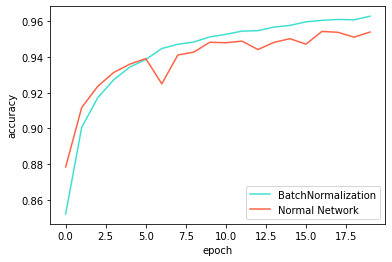
学習結果からわかる通り、バッチ正規化を加えることでテスト精度が高い水準で安定させることが可能となります。

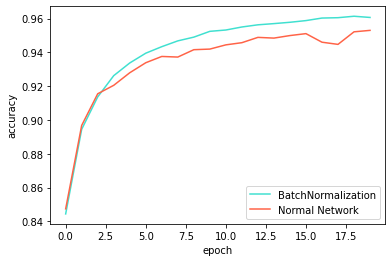

In [ ]:
x = range(20)
plt.plot(x, bn_acc_list, color='turquoise')
plt.plot(x, nobn_acc_list, color='tomato')

plt.legend(['BatchNormalization', 'Normal Network'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

次にAdamで学習した場合も含めてプロットしてみましょう。結果のグラフの特徴が以下と一致していれば学習成功です。<br>
・Adamで学習すると、SGDよりも学習が進みやすく、高い精度が実現できている。<br>
・バッチ正規化を加えないネットワークでは過学習により途中からテスト精度が急に低下している。<br>
バッチ正規化を加えることで正則化の役割も可能となっていることが読み取れます。

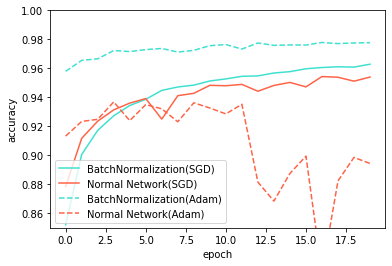

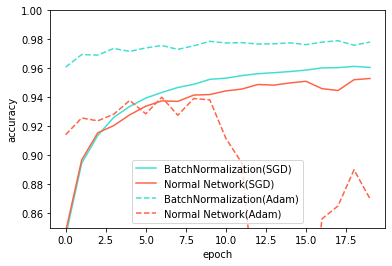

In [ ]:
x = range(20)
plt.plot(x, bn_acc_list, color='turquoise', linestyle = '-')
plt.plot(x, nobn_acc_list, color='tomato', linestyle='-')
plt.plot(x, adambn_acc_list, color='turquoise', linestyle = '--')
plt.plot(x, adamnobn_acc_list, color='tomato', linestyle='--')

plt.ylim((0.85, 1))

plt.legend(['BatchNormalization(SGD)', 'Normal Network(SGD)', 'BatchNormalization(Adam)', 'Normal Network(Adam)'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()